In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install ftfy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 640 kB/s 


In [ ]:
!pip install word2vec

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42 kB 941 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for word2vec: filename=word2vec-0.11.1-py2.py3-none-any.whl size=156431 sha256=1884d017046215c84fd929cddcbb25dd14667a4c6566e8b4191465c72900e4dd
  Stored in directory: /root/.cache/pip/wheels/c9/c0/d4/29d797817e268124a32b6cf8beb8b8fe87b86f099d5a049e61
Successfully built word2vec


In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
#from textblob import TextBlob
from math import log, sqrt, exp
import pandas as pd
import numpy as np
from numpy import sign

In [ ]:
import re
import warnings
warnings.filterwarnings("ignore")
import ftfy
#from bs4 import BeautifulSoup

from sklearn.metrics import  classification_report, confusion_matrix, accuracy_score

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()

from keras import optimizers
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv1D, Dense, Input, LSTM, Embedding, Dropout, Activation, MaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import gensim
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors
from gensim.test.utils import datapath

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('fivethirtyeight')

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
np.random.seed(1234)
DEPRES_NROWS = 15000  # number of rows to read from DEPRESSIVE_TWEETS_CSV
RANDOM_NROWS = 10000 # number of rows to read from RANDOM_TWEETS_CSV
MAX_SEQUENCE_LENGTH = 280 # Max tweet size
MAX_NB_WORDS = 25000
EMBEDDING_DIM = 300
TRAIN_SPLIT = 0.6
TEST_SPLIT = 0.2
LEARNING_RATE = 0.5
EPOCHS= 20

In [ ]:
 RANDOM_TWEETS_CSV = 'drive/MyDrive/capstone/sentimental_analysis_dataset.csv'
 DEPRESSIVE_TWEETS_CSV = 'drive/MyDrive/capstone/final_cleaned_tweets.csv'

In [ ]:
depressive_tweets_df = pd.read_csv(DEPRESSIVE_TWEETS_CSV, usecols = range(1,5), nrows = DEPRES_NROWS)
random_tweets_df = pd.read_csv(RANDOM_TWEETS_CSV, encoding = "ISO-8859-1", usecols = range(0,4), nrows = RANDOM_NROWS)

In [ ]:
depressive_tweets_df.head()

,id,time,tweet,hashtags
0,1497429703870799880,04:33:56,id send to whoever asked and was cute rn i wan...,[]
1,1497429442892898306,04:32:54,Paper cut my hand lmao,[]
2,1497429237279735809,04:32:05,Lmfaooooooo,[]
3,1497428460410654722,04:29:00,Gotta stop smoking because I'm starting a new ...,[]
4,1497428318852947972,04:28:26,might also be their new antidepressant is work...,[]


In [ ]:
random_tweets_df.head()

,ï»¿ItemID,Sentiment,SentimentSource,SentimentText
0,1,0,Sentiment140,is so sad for my APL frie...
1,2,0,Sentiment140,I missed the New Moon trail...
2,3,1,Sentiment140,omg its already 7:30 :O
3,4,0,Sentiment140,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,Sentiment140,i think mi bf is cheating on me!!! ...


**Preprocessing**

In [ ]:
emojies = [":‑)", ":)", ":D", ":o)", ":]", ":3", ":c)", ":>", "=]", "8)", "=)", ":}", ":^)", ":っ)", ":‑D", "8‑D", "8D", "x‑D", "xD", "X‑D", "XD", "=‑D", "=D", "=‑3", "=3", "B^D", ":-))", ">:[", ":‑(", ":(", ":‑c", ":c", ":‑<", ":っC", ":<", ":‑[", ":[", ":{", ";(", ":-||", ":@", ">:(", ":'‑(", ":'(", ":'‑)", ":')", "D:<", "D:", "D8", "D;", "D=", "DX", "v.v", "D‑':", ">:O", ":‑O", ":O", ":‑o", ":o", "8‑0", "O_O", "o‑o", "O_o", "o_O", "o_o", "O-O", ":*", ":-*", ":^*", "(", "}{'", ")", ";‑)", ";)", "*-)", "*)", ";‑]", ";]", ";D", ";^)", ":‑,", ">:P", ":‑P", ":P", "X‑P", "x‑p", "xp", "XP", ":‑p", ":p", "=p", ":‑Þ", ":Þ", ":þ", ":‑þ", ":‑b", ":b", "d:", ">:\\", ">:/", ":‑/", ":‑.", ":/", ":\\", "=/", "=\\", ":L", "=L", ":S", ">.<", ":|", ":‑|", ":$", ":‑X", ":X", ":‑#", ":#", "O:‑)", "0:‑3", "0:3", "0:‑)", "0:)", "0;^)", ">:)", ">;)", ">:‑)", "}:‑)", "}:)", "3:‑)", "3:)", "o/\o", "^5", ">_>^", "^<_<", "|;‑)", "|‑O", ":‑J", ":‑&", ":&", "#‑)", "%‑)", "%)", ":‑###..", ":###..", "<:‑|", "<*)))‑{", "><(((*>", "><>", "\o/", "*\0/*", "@}‑;‑'‑‑‑", "@>‑‑>‑‑", "~(_8^(I)", "5:‑)", "~:‑\\", "//0‑0\\\\", "*<|:‑)", "=:o]", "7:^]", ",:‑)", "</3", "<3"]

In [ ]:
# Expand Contraction
cList = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}

c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text)

In [ ]:

pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

In [ ]:
def clean_tweets(tweets):
    cleaned_tweets = []
    for tweet in tweets:
        tweet = str(tweet)
        # if url links, then don't append to avoid news articles, etc.
        # Check tweet length, save those > 6 (length of word "lonely")
        if re.match("(\w+:\/\/\S+)", tweet) == None and len(tweet) > 10:
            tweet = re.sub(r"http\S+", "", tweet)
            tweet = re.sub(r'www.+', "", tweet)
            #remove hashtags, @mention, emoji and image URLs
            tweet = ' '.join(re.sub("(@[A-Za-z0-9]+)|(\#[A-Za-z0-9]+)|(<Emoji:.*>)|(pic\.twitter\.com\/.*)", " ", tweet).split())
            # Remove HTML special entities (e.g. &amp;)
            tweet = re.sub(r'\&\w*;', '', tweet)
            #Convert @username to AT_USER
            tweet = re.sub('@[^\s]+','',tweet)
            # Remove tickers
            tweet = re.sub(r'\$\w*', '', tweet)
            # To lowercase
            tweet = tweet.lower()
            # Remove hyperlinks
            tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
            # Remove hashtags
            #tweet = re.sub(r'#\w*', '', tweet)
            # Remove Punctuation and split 's, 't, 've with a space for filter
            #tweet = re.sub(r'[' + punctuation.replace('@', '') + ']+', ' ', tweet)
            # Remove words with 2 or fewer letters
            tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
            # Remove whitespace (including new line characters)
            tweet = re.sub(r'\s\s+', ' ', tweet)
            # Remove single space remaining at the front of the tweet.
            tweet = tweet.lstrip(' ') 
            # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
            tweet = ''.join(c for c in tweet if c <= '\uFFFF')
            #fix weirdly encoded texts
            tweet = ftfy.fix_text(tweet)
            #expand contraction
            tweet = expandContractions(tweet)
            #remove punctuation
            tweet = ' '.join(re.sub("([^0-9A-Za-z \t])", " ", tweet).split())
            
            neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], tweet)
            letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
            
            # Tokenize and join to remove unneccessary white spaces
            words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
            #return (" ".join(words)).strip()

            #stop words
            stop_words = set(stopwords.words('english'))
            stop_words.update(("mon","tue","wed","thu","fri","sat","sun","sunday","monday","tuesday","thursday","friday","saturday","sunday","thurs","thur","tues"))
            stop_words.update(("january","february","march","april","may","june","july","august",
              "september","october","november","december","jan","feb","mar","apr",
              "may","jun","jul","aug","sep","oct","nov","dec", "twitter", "thanking","thanks"))
    
            word_tokens = nltk.word_tokenize(tweet) 
            filtered_sentence = [w for w in word_tokens if not w in stop_words]
            tweet = ' '.join(filtered_sentence)

            #stemming words
            tweet = PorterStemmer().stem(tweet)
            
            cleaned_tweets.append(tweet)

    return cleaned_tweets

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#Applying the preprocessing clean_text function to every element in the depressive tweets and random tweets data.
depressive_tweets_arr = [x for x in depressive_tweets_df['tweet']]
random_tweets_arr = [x for x in random_tweets_df['SentimentText']]
X_d = clean_tweets(depressive_tweets_arr)
X_r = clean_tweets(random_tweets_arr)

In [ ]:
X_d[0:10]

['send whoever asked cute want sexual attentionnnnn fucking idiots said antidepressants destroy sex drive wronnnggg',
 'paper cut hand lmao',
 'lmfaooooooo',
 'got ta stop smoking starting new antidepressant need know working call break',
 'might also new antidepressant working hahaha',
 'like antidepressant properties bingqiu wedding storyboard cures il',
 'nice crack pipe burn lol also factual people use drug cope even prescribed like antidepressants alcohol maybe soon use subject one judge use humor difficult subjects time lol',
 'client became violent office tell feel feel since doctor put antidepressants feel anything nothing dead thing asked tell doctor stopped meds got happier said happy alway',
 'allergic antidepressants lmaooo',
 'finally got prescribed antidepressant days ago sleeping extra']

# Data Visualization with Word Cloud

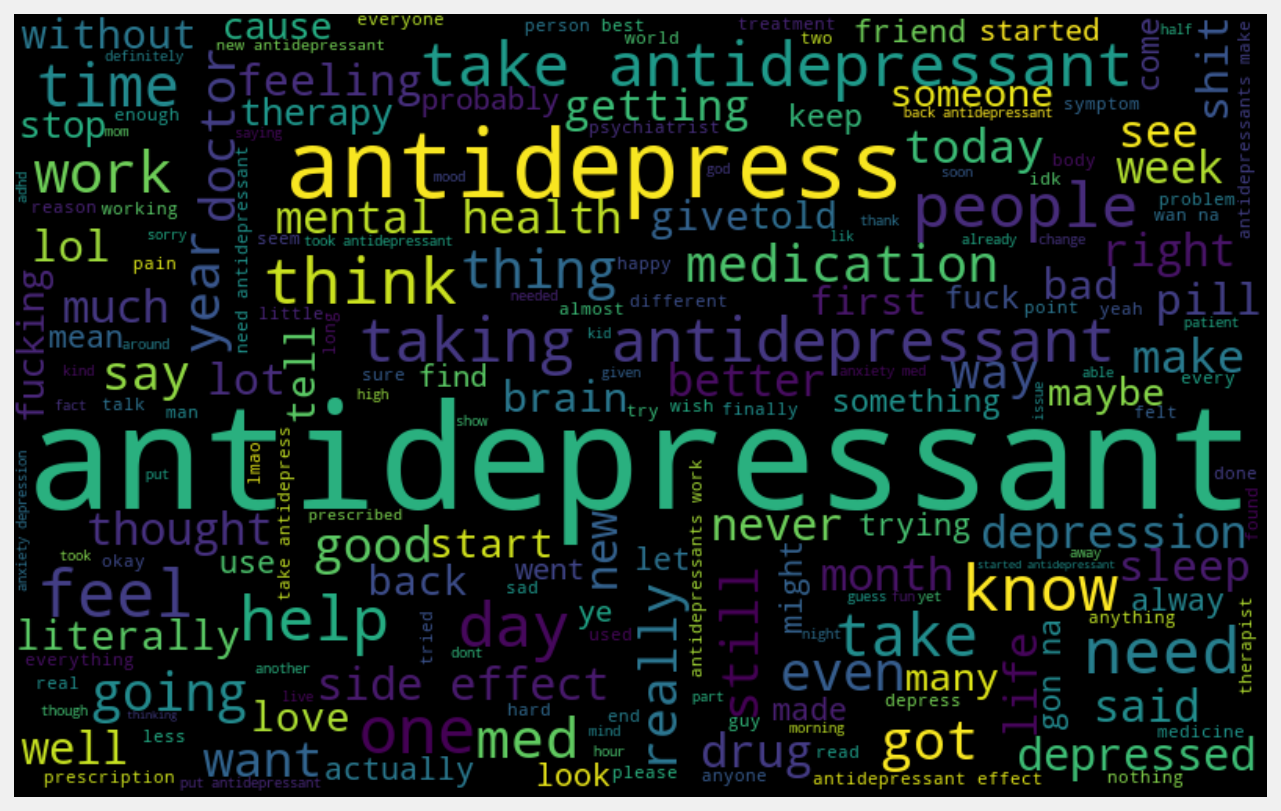

In [ ]:
# Depression Tweets
all_words = ' '.join(text for text in X_d)
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

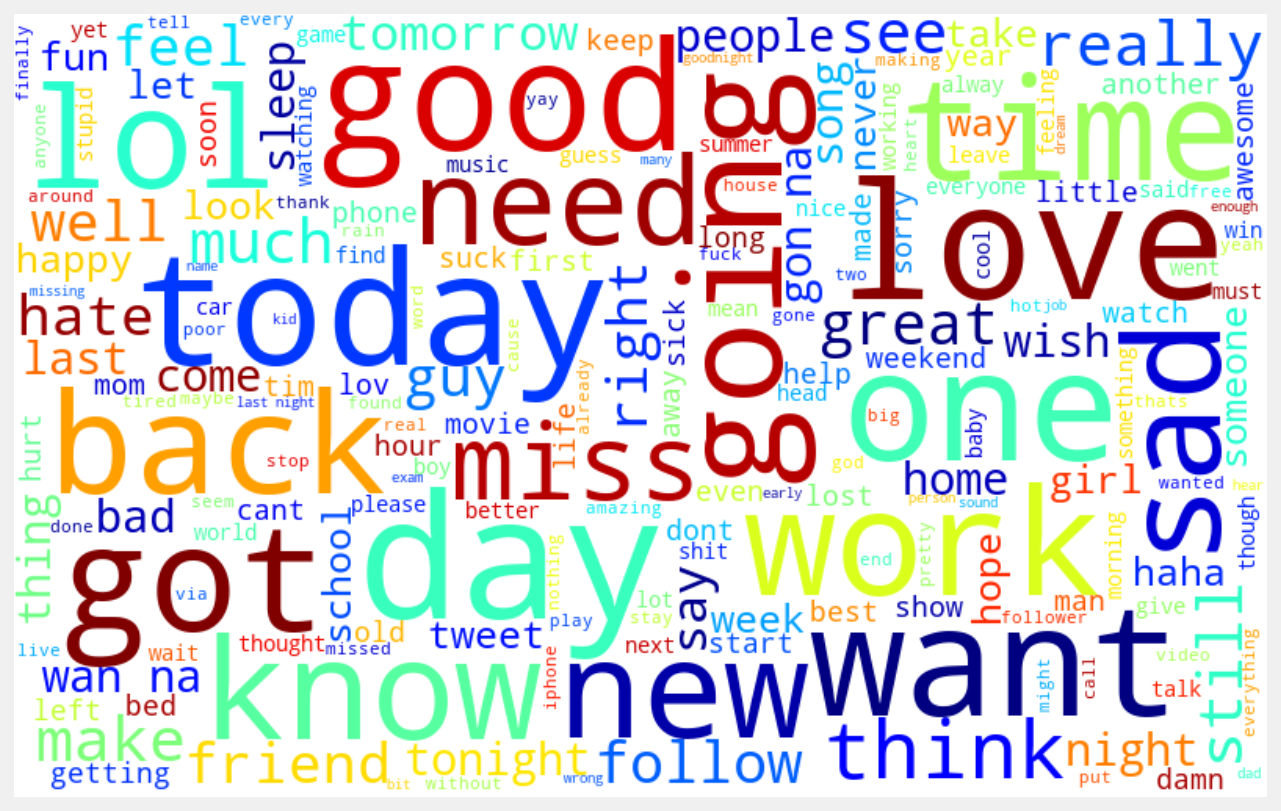

In [ ]:
# Random Tweets
all_words = ' '.join(text for text in X_r)
wordcloud = WordCloud(background_color='white', colormap='jet', width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# Tokenizer

In [ ]:
X_d

['send whoever asked cute want sexual attentionnnnn fucking idiots said antidepressants destroy sex drive wronnnggg',
 'paper cut hand lmao',
 'lmfaooooooo',
 'got ta stop smoking starting new antidepressant need know working call break',
 'might also new antidepressant working hahaha',
 'like antidepressant properties bingqiu wedding storyboard cures il',
 'nice crack pipe burn lol also factual people use drug cope even prescribed like antidepressants alcohol maybe soon use subject one judge use humor difficult subjects time lol',
 'client became violent office tell feel feel since doctor put antidepressants feel anything nothing dead thing asked tell doctor stopped meds got happier said happy alway',
 'allergic antidepressants lmaooo',
 'finally got prescribed antidepressant days ago sleeping extra',
 'billi quickly become antidepressant song feeling blah tough day work pressed play hype earthgang',
 'would seriously nuts best antidepress',
 'perfect carry antidepressants anxiety pil

In [ ]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X_d + X_r)

In [ ]:
sequences_d = tokenizer.texts_to_sequences(X_d)
sequences_r = tokenizer.texts_to_sequences(X_r)

In [ ]:
print(len(sequences_d))
print(len(sequences_r))

14938
9914


In [ ]:
wi = tokenizer.word_index
wi

{'antidepressants': 1,
 'antidepressant': 2,
 'like': 3,
 'antidepress': 4,
 'get': 5,
 'take': 6,
 'need': 7,
 'feel': 8,
 'day': 9,
 'one': 10,
 'taking': 11,
 'know': 12,
 'good': 13,
 'got': 14,
 'time': 15,
 'work': 16,
 'people': 17,
 'think': 18,
 'depression': 19,
 'really': 20,
 'back': 21,
 'today': 22,
 'going': 23,
 'much': 24,
 'new': 25,
 'make': 26,
 'also': 27,
 'help': 28,
 'want': 29,
 'would': 30,
 'still': 31,
 'even': 32,
 'na': 33,
 'love': 34,
 'meds': 35,
 'life': 36,
 'anxiety': 37,
 'see': 38,
 'better': 39,
 'last': 40,
 'lol': 41,
 'years': 42,
 'never': 43,
 'could': 44,
 'right': 45,
 'well': 46,
 'bad': 47,
 'first': 48,
 'getting': 49,
 'sad': 50,
 'year': 51,
 'way': 52,
 'effects': 53,
 'therapy': 54,
 'stop': 55,
 'health': 56,
 'sleep': 57,
 'say': 58,
 'night': 59,
 'started': 60,
 'mental': 61,
 'week': 62,
 'without': 63,
 'made': 64,
 'gon': 65,
 'every': 66,
 'doctor': 67,
 'days': 68,
 'said': 69,
 'since': 70,
 'side': 71,
 'many': 72,
 'shit'

In [ ]:
word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Found 22131 unique tokens


In [ ]:
data_d = pad_sequences(sequences_d, maxlen=MAX_SEQUENCE_LENGTH) # add 0 in front of sequences such that every seq has same length
data_r = pad_sequences(sequences_r, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data_d tensor:', data_d.shape)
print('Shape of data_r tensor:', data_r.shape)

Shape of data_d tensor: (14938, 280)
Shape of data_r tensor: (9914, 280)


In [ ]:
# Assigning labels to the depressive tweets and random tweets data
labels_d = np.array([1] * DEPRES_NROWS)
labels_r = np.array([0] * RANDOM_NROWS)

# Splitting the arrays into training (60%), validation (20%), and testing data (20%)
perm_d = np.random.permutation(len(data_d))
idx_train_d = perm_d[:int(len(data_d)*(TRAIN_SPLIT))]
idx_test_d = perm_d[int(len(data_d)*(TRAIN_SPLIT)):int(len(data_d)*(TRAIN_SPLIT+TEST_SPLIT))]
idx_val_d = perm_d[int(len(data_d)*(TRAIN_SPLIT+TEST_SPLIT)):]

perm_r = np.random.permutation(len(data_r))
idx_train_r = perm_r[:int(len(data_r)*(TRAIN_SPLIT))]
idx_test_r = perm_r[int(len(data_r)*(TRAIN_SPLIT)):int(len(data_r)*(TRAIN_SPLIT+TEST_SPLIT))]
idx_val_r = perm_r[int(len(data_r)*(TRAIN_SPLIT+TEST_SPLIT)):]

# Combine depressive tweets and random tweets arrays
data_train = np.concatenate((data_d[idx_train_d], data_r[idx_train_r]))
labels_train = np.concatenate((labels_d[idx_train_d], labels_r[idx_train_r]))
data_test = np.concatenate((data_d[idx_test_d], data_r[idx_test_r]))
labels_test = np.concatenate((labels_d[idx_test_d], labels_r[idx_test_r]))
data_val = np.concatenate((data_d[idx_val_d], data_r[idx_val_r]))
labels_val = np.concatenate((labels_d[idx_val_d], labels_r[idx_val_r]))

# Shuffling
perm_train = np.random.permutation(len(data_train))
data_train = data_train[perm_train]
labels_train = labels_train[perm_train]
perm_test = np.random.permutation(len(data_test))
data_test = data_test[perm_test]
labels_test = labels_test[perm_test]
perm_val = np.random.permutation(len(data_val))
data_val = data_val[perm_val]
labels_val = labels_val[perm_val]

In [ ]:
from tensorflow import keras
import tensorflow as tf

In [ ]:
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

In [ ]:
#f1, precision, and recall scores
print(classification_report(labels_test, labels_pred))

NameError: ignored

In [ ]:
import numpy as np

embedding_dict={}
with open("/content/drive/MyDrive/capstone/glove.twitter.27B.100d.txt", "r") as f:
  for line in f:
    values=line.split()
    word=values[0]
    vectors=np.asarray(values[1:],"float32")
    embedding_dict[word]=vectors
f.close()


In [ ]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))
for word,i in word_index.items():
  if i<num_words:
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
      embedding_matrix[i]=emb_vec
      LEARNING_RATE=3e-4

In [ ]:
from keras.models import sequential
from keras.layers import Embedding,LSTM,Dense,Dropout
from keras.initializers import Constant
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
model = Sequential()
# Embedded layer
model.add(Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),input_length=MAX_SEQUENCE_LENGTH, trainable=False))


# LSTM Layer
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
# LSTM Layer
model.add(LSTM(300))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
nadam = tf.keras.optimizers.Nadam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['acc'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 280, 100)          2213200   
                                                                 
 conv1d (Conv1D)             (None, 280, 32)           9632      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 140, 32)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 140, 32)           0         
                                                                 
 lstm (LSTM)                 (None, 300)               399600    
                                                                 
 dropout_1 (Dropout)         (None, 300)               0         
                                                        

In [ ]:
early_stop = EarlyStopping(monitor='val_acc', mode='max', patience=3)

hist = model.fit(data_train, labels_train, \
        validation_data=(data_val, labels_val), \
        epochs=EPOCHS, batch_size=40, shuffle=True, \
        callbacks=[early_stop])

Epoch 1/20
373/373 [==============================] - 23s 17ms/step - loss: 0.3327 - acc: 0.8417 - val_loss: 0.2831 - val_acc: 0.8694
Epoch 2/20
373/373 [==============================] - 6s 15ms/step - loss: 0.2539 - acc: 0.8865 - val_loss: 0.2539 - val_acc: 0.8841
Epoch 3/20
373/373 [==============================] - 6s 17ms/step - loss: 0.2249 - acc: 0.9013 - val_loss: 0.2433 - val_acc: 0.8890
Epoch 4/20
373/373 [==============================] - 6s 15ms/step - loss: 0.2003 - acc: 0.9129 - val_loss: 0.2391 - val_acc: 0.8978
Epoch 5/20
373/373 [==============================] - 6s 15ms/step - loss: 0.1827 - acc: 0.9216 - val_loss: 0.2274 - val_acc: 0.9024
Epoch 6/20
373/373 [==============================] - 6s 15ms/step - loss: 0.1646 - acc: 0.9295 - val_loss: 0.2186 - val_acc: 0.9075
Epoch 7/20
373/373 [==============================] - 6s 15ms/step - loss: 0.1979 - acc: 0.9164 - val_loss: 0.2450 - val_acc: 0.8914
Epoch 8/20
373/373 [==============================] - 6s 17ms/step -

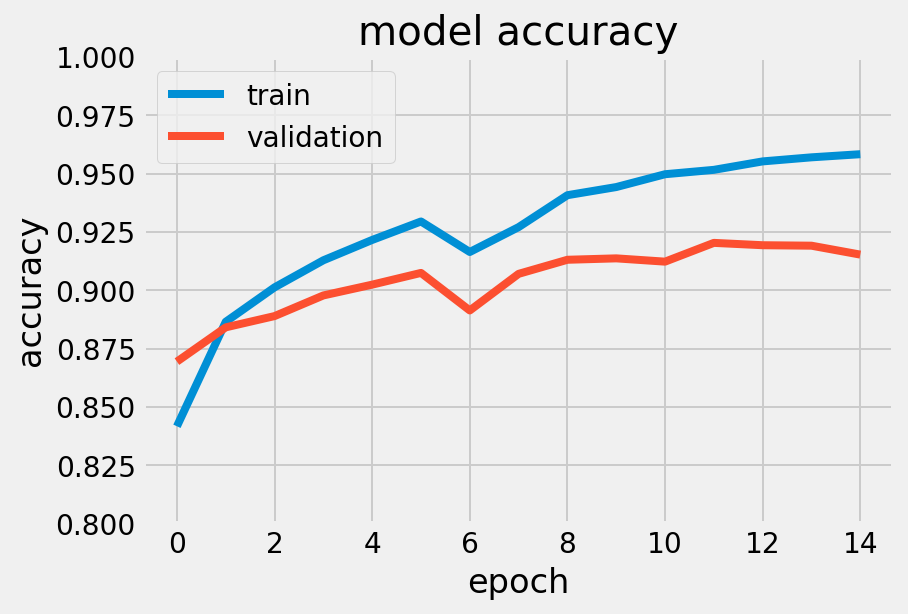

In [ ]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.ylim(0.8,1)
plt.show()

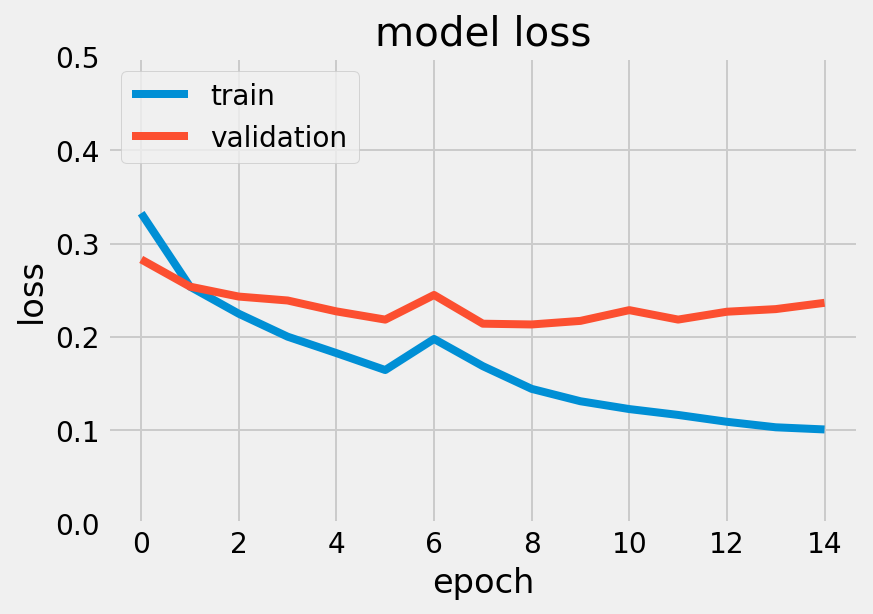

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim((0,.5))
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
labels_pred = model.predict(data_test)
labels_pred = np.round(labels_pred.flatten())
accuracy = accuracy_score(labels_test, labels_pred)
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 91.39%


In [ ]:
model.save('glove_model.pkl')

2022-07-29 09:11:30,910 : WARNING : Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: glove_model.pkl/assets


2022-07-29 09:11:31,938 : INFO : Assets written to: glove_model.pkl/assets
2022-07-29 09:11:36,689 : WARNING : <keras.layers.recurrent.LSTMCell object at 0x7f73265673d0> has the same name 'LSTMCell' as a built-in Keras object. Consider renaming <class 'keras.layers.recurrent.LSTMCell'> to avoid naming conflicts when loading with `tf.keras.models.load_model`. If renaming is not possible, pass the object in the `custom_objects` parameter of the load function.


In [ ]:
from google.colab import files


In [ ]:
files


<module 'google.colab.files' from '/usr/local/lib/python3.7/dist-packages/google/colab/files.py'>

# New Section